# Проект: классификация

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [179]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [180]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [181]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

В признаке *"job"* пропущенные значения обозначены словом: **unknown**.

### Задание 3

In [182]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def make_convert(balance):
    balance = str(balance)
    if balance != 'unknown':
        balance = balance.replace(',00', '')
        balance = balance.replace('$', '')
        balance = balance.replace(' ', '')
        return float(balance)
    else:
        return np.nan

In [183]:
balance_new = df['balance'].apply(make_convert)
df['balance'] = balance_new

In [184]:
print(f"Среднее значение по преобразованному в корректный вид признаку balance: {round(df['balance'].mean(),3)}")

Среднее значение по преобразованному в корректный вид признаку balance: 1529.129


### Задание 4

In [185]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

In [186]:
print(f"Среднее значение по преобразованному в корректный вид признаку balance: {round(df['balance'].mean(),3)}")

Среднее значение по преобразованному в корректный вид признаку balance: 1526.936


### Задание 5

In [187]:
df_job_mode = df['job'].mode()
df_education_mode = df['education'].mode()

In [188]:
df['job'].replace(['unknown'], df_job_mode, inplace=True)
df['education'].replace(['unknown'], df_education_mode, inplace=True)

In [189]:
round(df[(df['job'] == 'management')&(df['education'] == 'secondary')]['balance'].mean(),3)

1598.883

### Задание 6

In [190]:
# удалите все выбросы для признака balance
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr*1.5)
    upper_bound = quartile_3 + (iqr*1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(f'Нижняя граница по методу Тьюки: {round(lower_bound)}')
print(f'Верхняя граница по методу Тьюки: {round(upper_bound)}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

df = cleaned

Нижняя граница по методу Тьюки: -2241
Верхняя граница по методу Тьюки: 4063
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

In [191]:
df['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

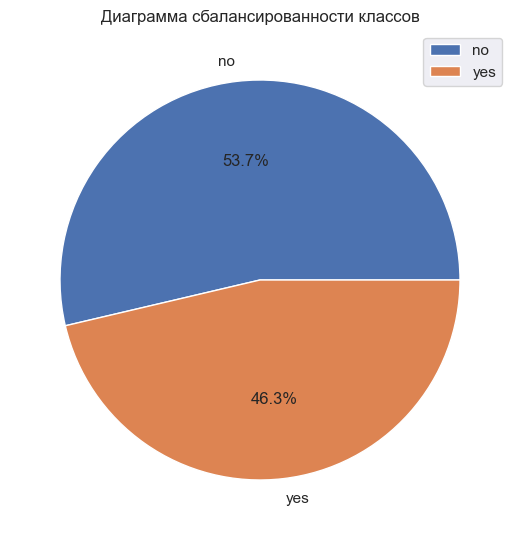

In [192]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
deposit_combinations = df['deposit'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    deposit_combinations,
    labels=deposit_combinations.index,
    autopct='%.1f%%',
    
);
axes.set_title('Диаграмма сбалансированности классов')
axes.legend()

*Диаграмма выше показывает сбалансированный класс распределения целевой переменной. Нет существенного большинства между тех кто открыл счет или отказался.*

### Задания 2 и 3

In [193]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
print(round(df[['age','balance','duration']].describe()))
mode_age = df['age'].mode()
print(f'Самый частый возраст в данных: {mode_age}');
median_balance = df['balance'].median()
print(f'Медиана баланса в данных: {median_balance}');
median_duration = df['duration'].median()
print(f'Медиана продолжительности в данных: {median_duration}');

           age  balance  duration
count  10105.0  10105.0   10105.0
mean      41.0    808.0     369.0
std       12.0    994.0     347.0
min       18.0  -2049.0       2.0
25%       32.0     95.0     137.0
50%       38.0    445.0     252.0
75%       48.0   1227.0     490.0
max       95.0   4063.0    3881.0
Самый частый возраст в данных: 0    31
Name: age, dtype: int64
Медиана баланса в данных: 445.0
Медиана продолжительности в данных: 252.0


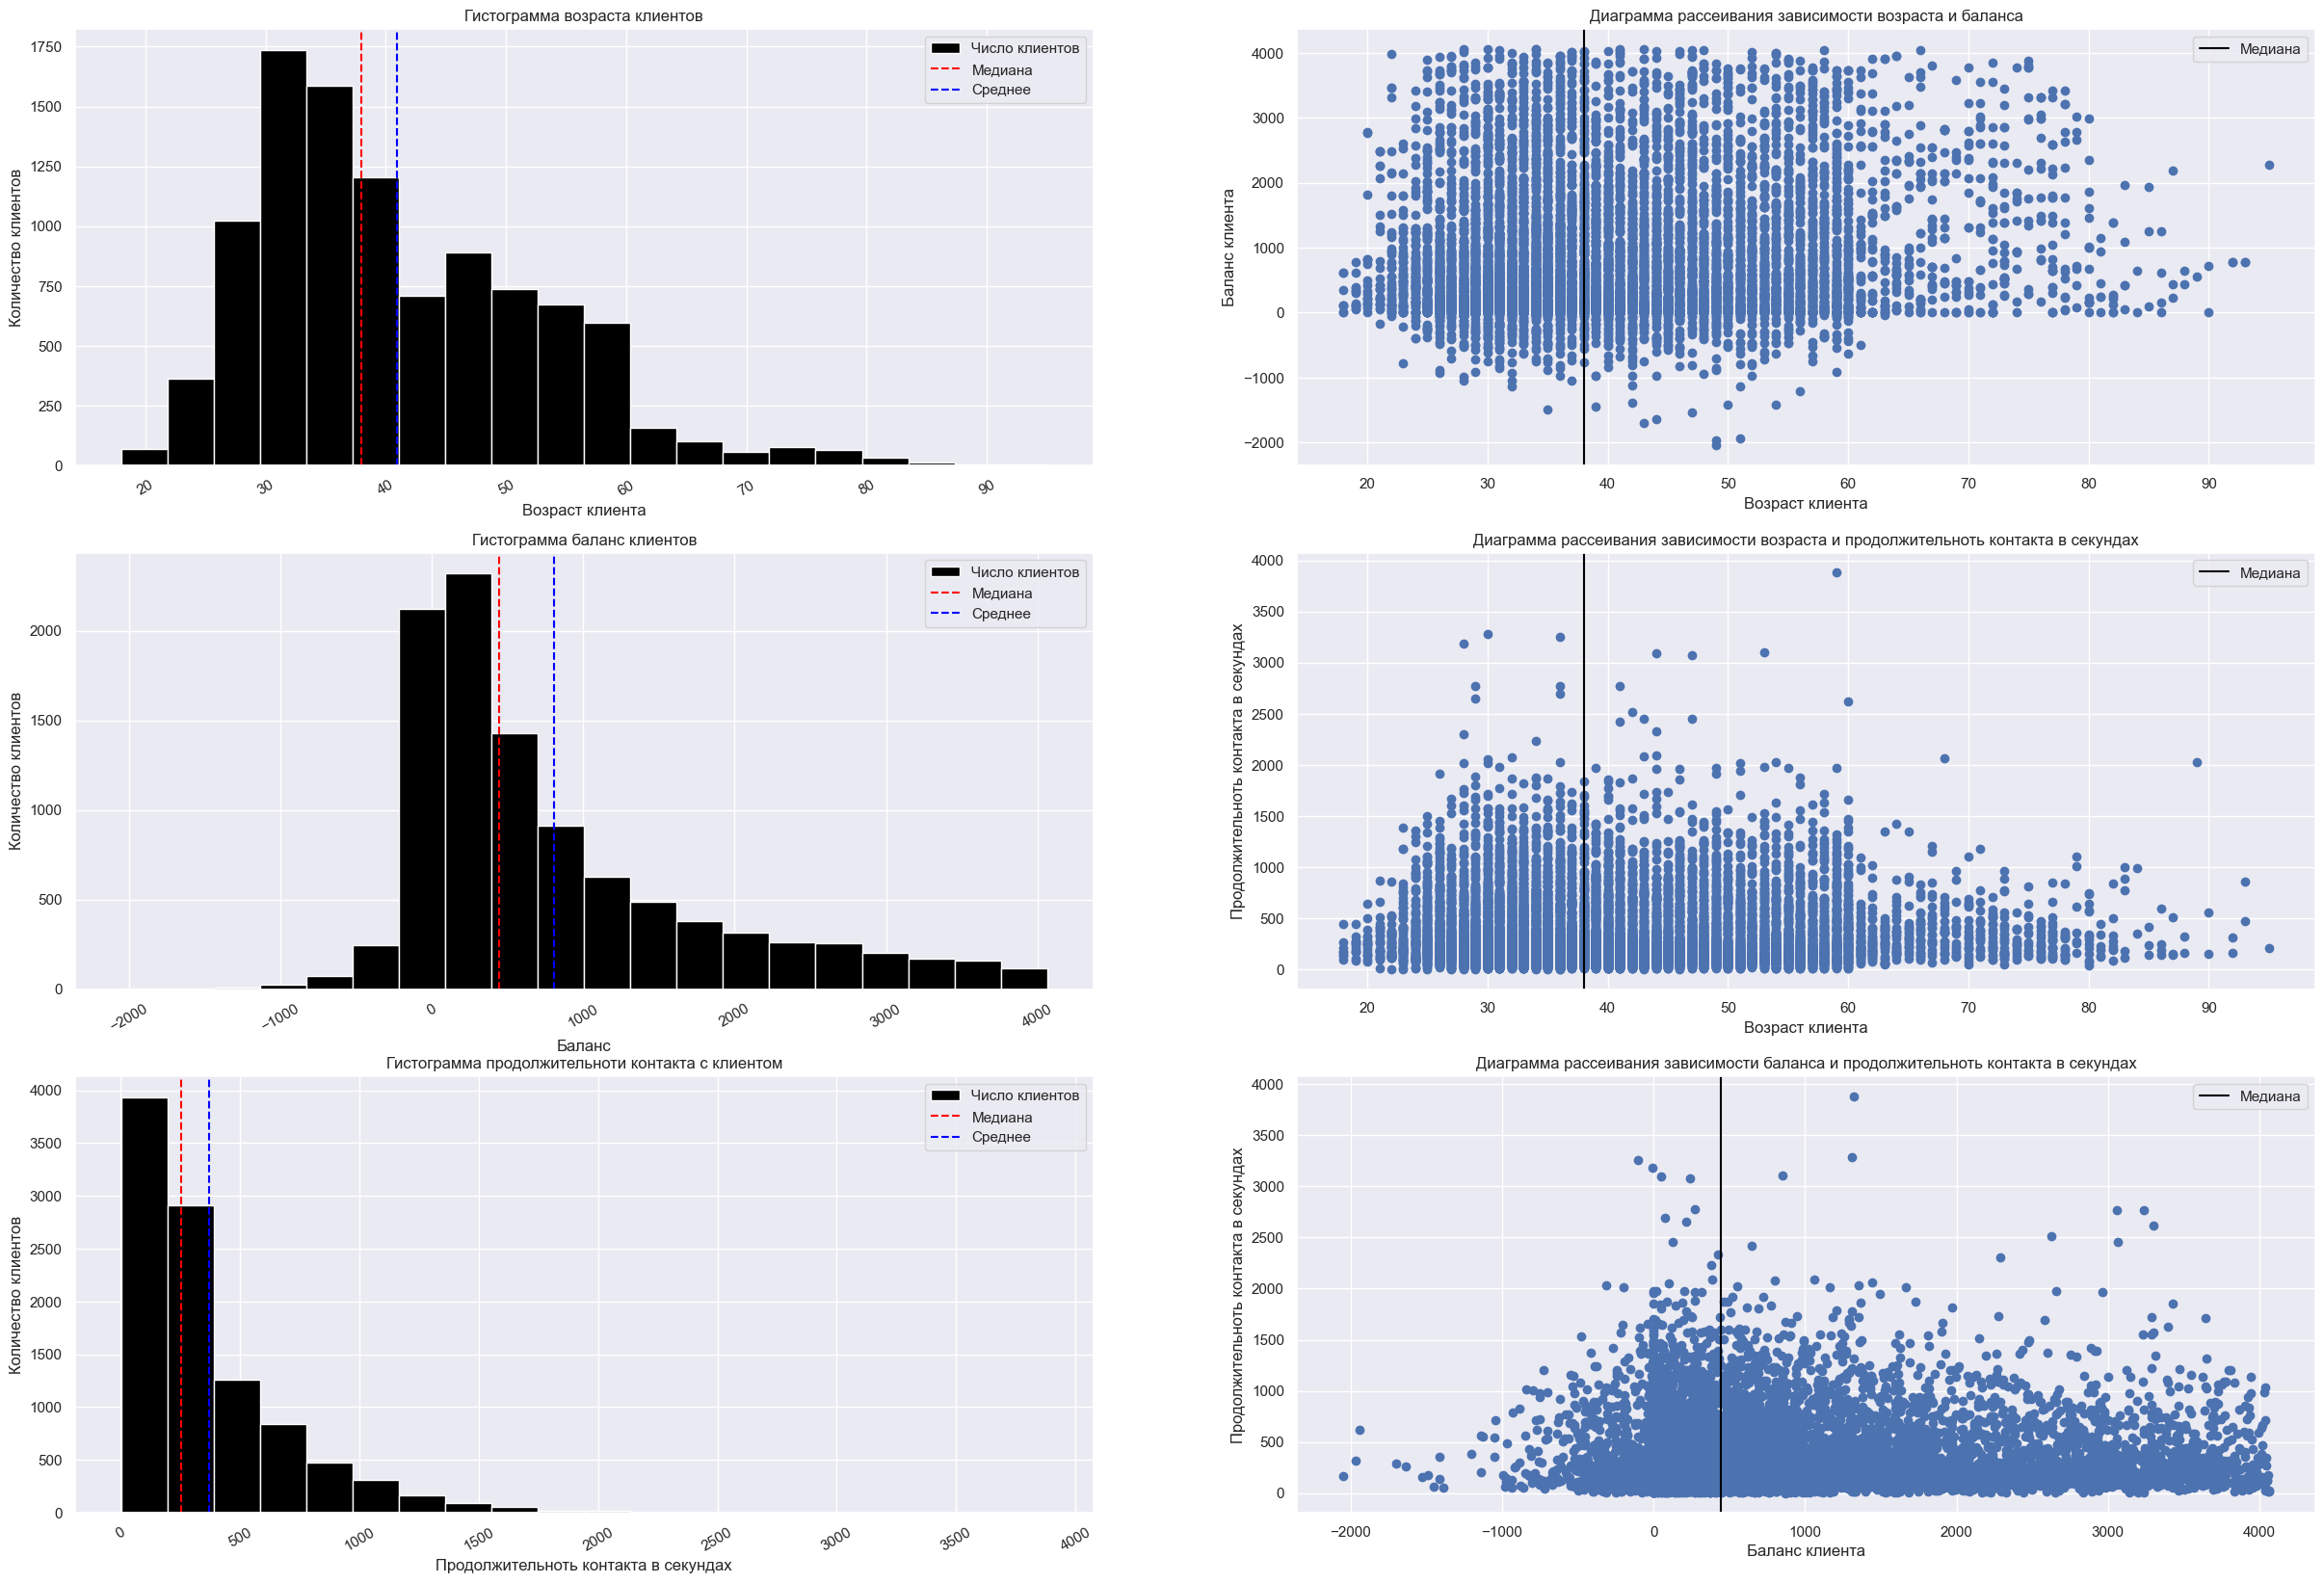

In [194]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))

# гистограмма возраста
axes[0][0].hist(
    x=df['age'], label=['Число клиентов'], color='black', bins=20
)
axes[0][0].axvline (x=df['age'].median(), color='red', linestyle='--', label='Медиана')
axes[0][0].axvline (x=df['age'].mean(), color='blue', linestyle='--', label='Среднее')
axes[0][0].set_title('Гистограмма возраста клиентов')
axes[0][0].set_xlabel('Возраст клиента')
axes[0][0].set_ylabel('Количество клиентов')
axes[0][0].xaxis.set_tick_params(rotation=30)
axes[0][0].legend()

# диаграмма рассеивания возраст и баланс
axes[0][1].scatter(
    x=df['age'],
    y=df['balance']
);
axes[0][1].axvline (x=df['age'].median(), color='black', linestyle='-', label='Медиана')
axes[0][1].set_title('Диаграмма рассеивания зависимости возраста и баланса')
axes[0][1].set_xlabel('Возраст клиента')
axes[0][1].set_ylabel('Баланс клиента')
axes[0][1].legend()

# диаграмма рассеивания возраст и продолжительность контакта
axes[1][1].scatter(
    x=df['age'],
    y=df['duration']
);
axes[1][1].axvline (x=df['age'].median(), color='black', linestyle='-', label='Медиана')
axes[1][1].set_title('Диаграмма рассеивания зависимости возраста и продолжительноть контакта в секундах')
axes[1][1].set_xlabel('Возраст клиента')
axes[1][1].set_ylabel('Продолжительноть контакта в секундах')
axes[1][1].legend()

# гистограмма баланса
axes[1][0].hist(
    x=df['balance'], label=['Число клиентов'], color='black', bins=20
)
axes[1][0].axvline (x=df['balance'].median(), color='red', linestyle='--', label='Медиана')
axes[1][0].axvline (x=df['balance'].mean(), color='blue', linestyle='--', label='Среднее')
axes[1][0].set_title('Гистограмма баланс клиентов')
axes[1][0].set_xlabel('Баланс')
axes[1][0].set_ylabel('Количество клиентов')
axes[1][0].xaxis.set_tick_params(rotation=30)
axes[1][0].legend()

# гистограмма
axes[2][0].hist(
    x=df['duration'], label=['Число клиентов'], color='black', bins=20
)
axes[2][0].axvline (x=df['duration'].median(), color='red', linestyle='--', label='Медиана')
axes[2][0].axvline (x=df['duration'].mean(), color='blue', linestyle='--', label='Среднее')
axes[2][0].set_title('Гистограмма продолжительноти контакта с клиентом')
axes[2][0].set_xlabel('Продолжительноть контакта в секундах')
axes[2][0].set_ylabel('Количество клиентов')
axes[2][0].xaxis.set_tick_params(rotation=30)
axes[2][0].legend()

# диаграмма рассеивания баланса и продолжительности контакта
axes[2][1].scatter(
    x=df['balance'],
    y=df['duration']
);
axes[2][1].axvline (x=df['balance'].median(), color='black', linestyle='-', label='Медиана')
axes[2][1].set_title('Диаграмма рассеивания зависимости баланса и продолжительноть контакта в секундах')
axes[2][1].set_xlabel('Баланс клиента')
axes[2][1].set_ylabel('Продолжительноть контакта в секундах')
axes[2][1].legend()


- Минимальный возраст клиента 18 лет, максимальный - 95 лет.
- Чаще всего возраст 31 год.
- Основной кантенгент 25-40 лет, потом до 60 лет спад и дальше до 90 мало клиентов.
- Основной объем баланса от 0 до 1000 идет по возрасту от 25 до 60 лет. Высокий баланс среди клиентов наблюдается равномерно с 30 до 80 лет.
- Минусовой баланс бывает только с 20 до 60 лет замечен. У возрастных клиентов минусовых балансов не наблюдается.
- Продолжительность контактов в основном до 2000 секунд. Свыше у незначительных клиентов. Максимальный в 3881 кажется уже аномальным, так же как и минимальный - 2 секунды. 

### Задания 4 и 5

In [195]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

df.describe(include=object)



,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


<Axes: xlabel='deposit', ylabel='count'>

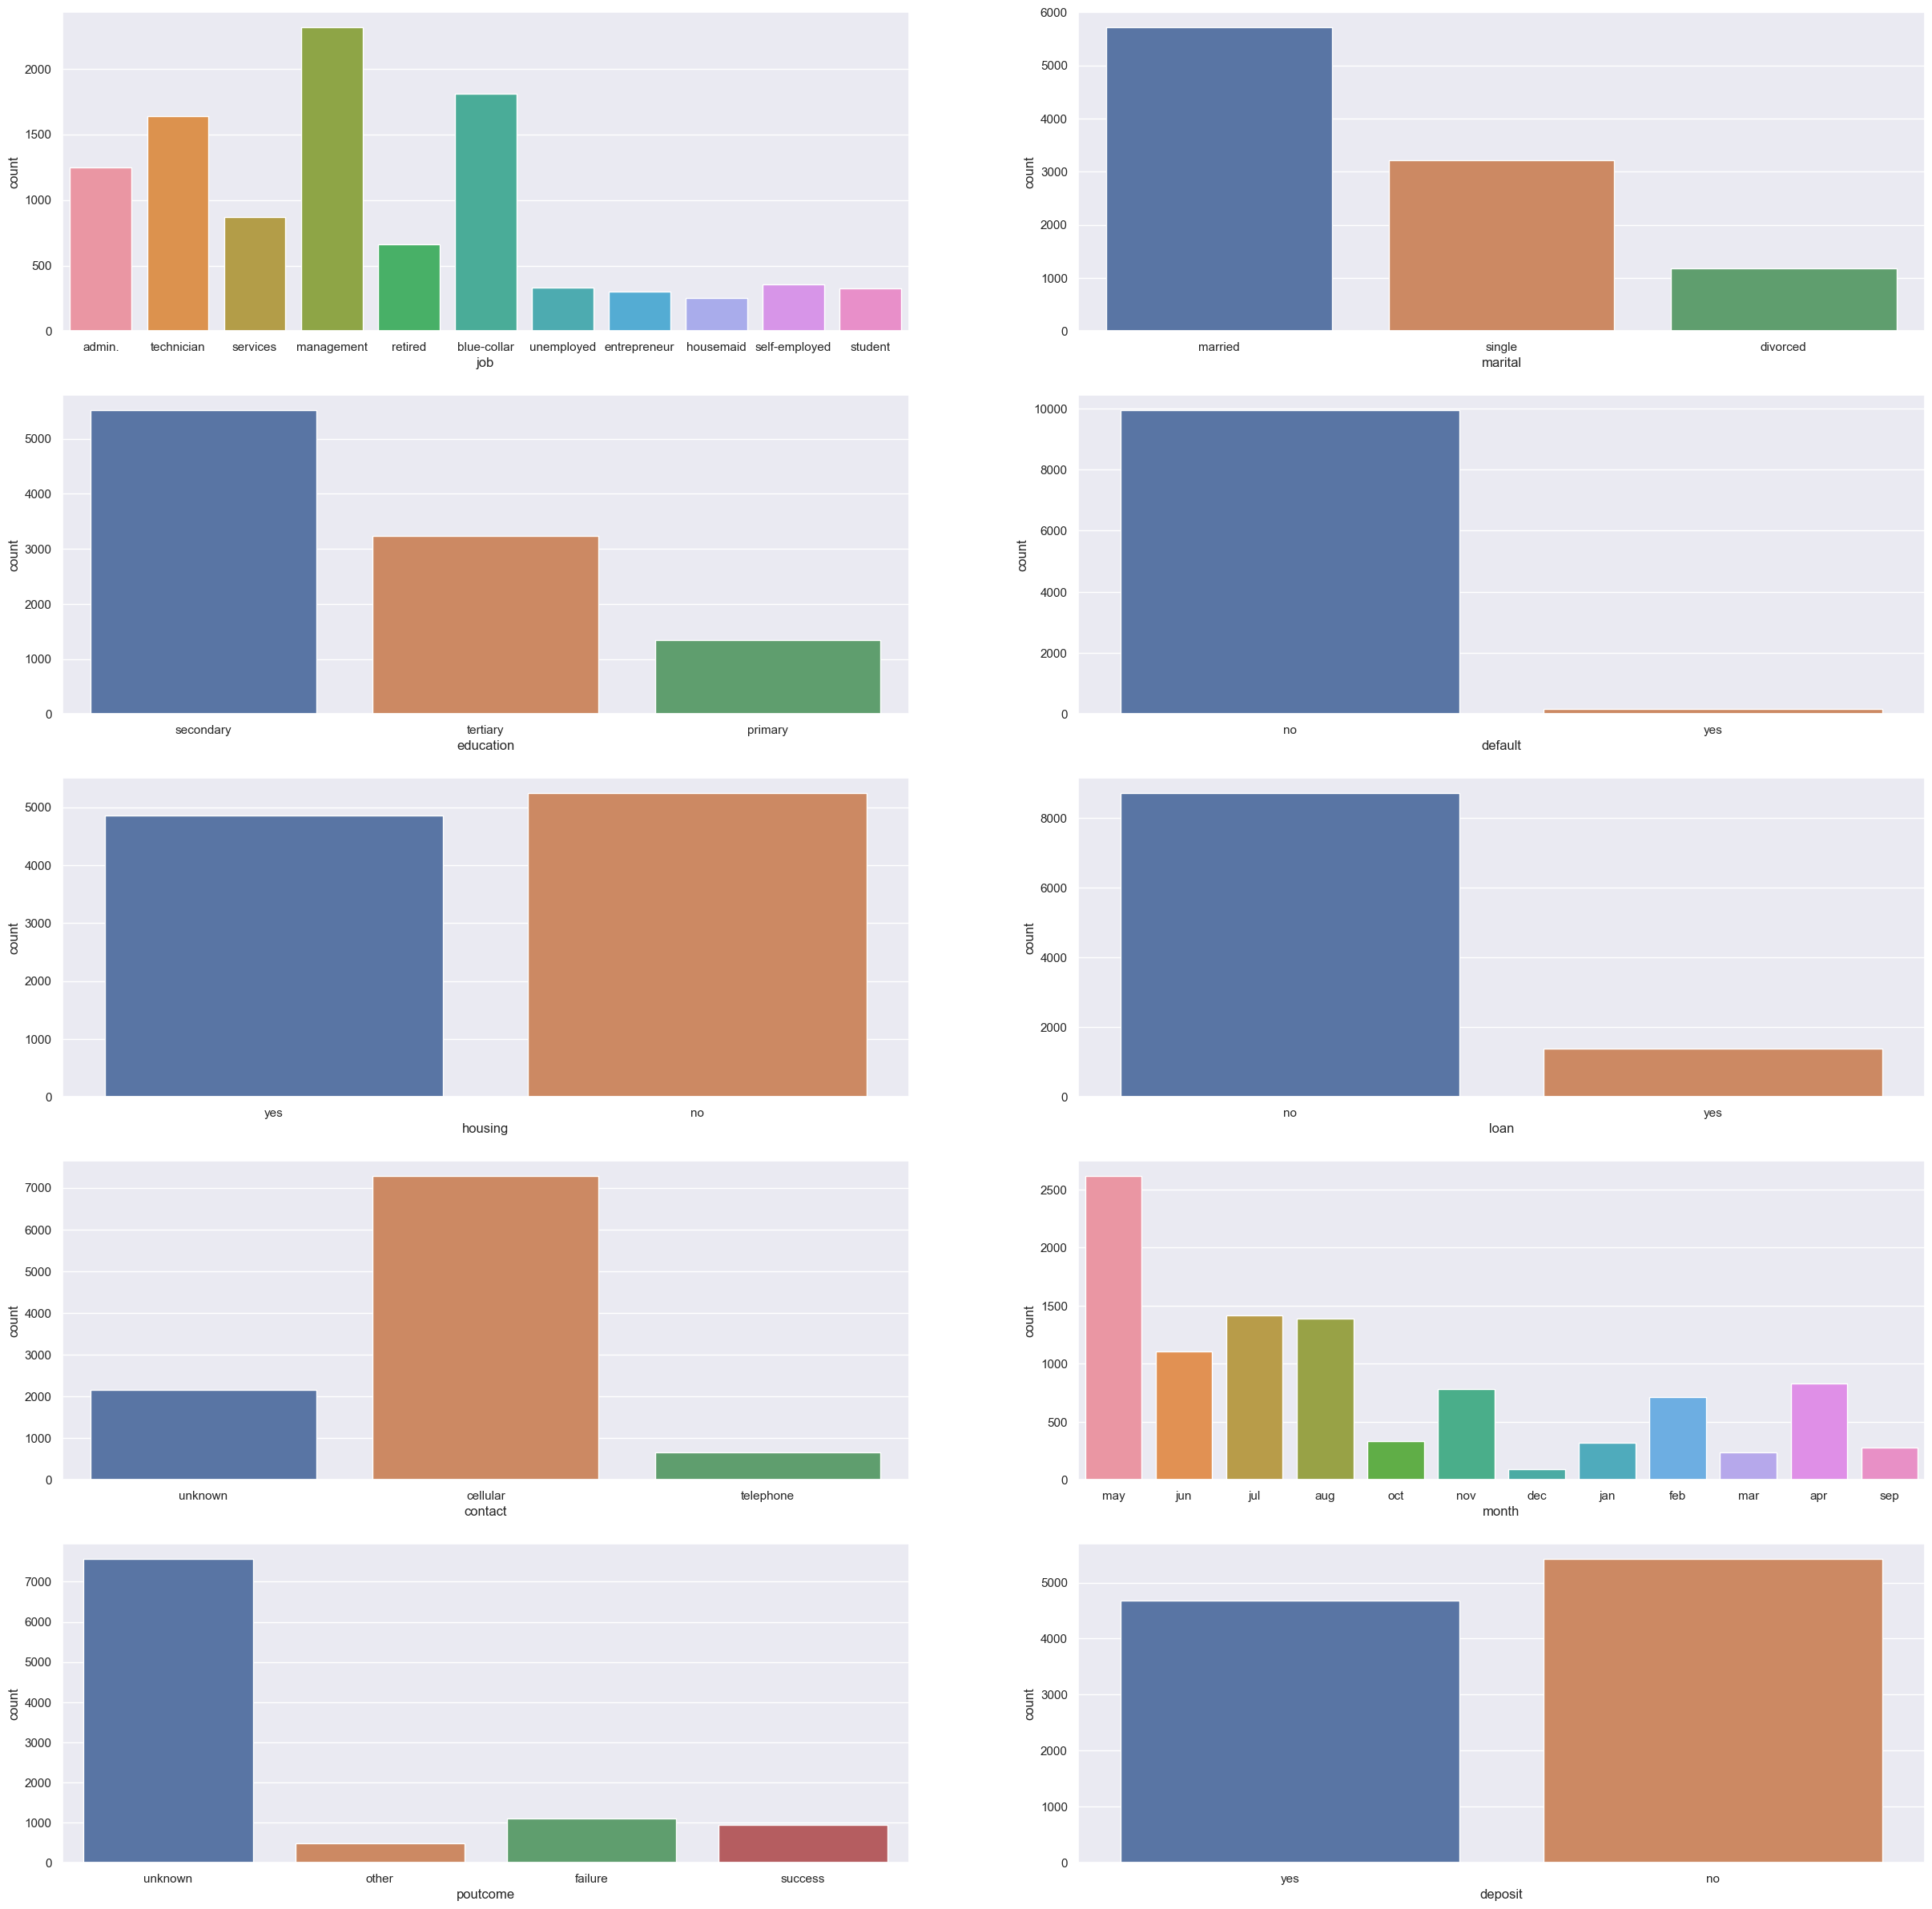

In [196]:
sns.set(rc={'figure.figsize':(30,30)})
plt.subplot(5, 2, 1)
sns.countplot(x='job', data=df)
plt.subplot(5, 2, 2)
sns.countplot(x='marital', data=df)
plt.subplot(5, 2, 3)
sns.countplot(x='education', data=df)
plt.subplot(5, 2, 4)
sns.countplot(x='default', data=df)
plt.subplot(5, 2, 5)
sns.countplot(x='housing', data=df)
plt.subplot(5, 2, 6)
sns.countplot(x='loan', data=df)
plt.subplot(5, 2, 7)
sns.countplot(x='contact', data=df)
plt.subplot(5, 2, 8)
sns.countplot(x='month', data=df)
plt.subplot(5, 2, 9)
sns.countplot(x='poutcome', data=df)
plt.subplot(5, 2, 10)
sns.countplot(x='deposit', data=df)


<Axes: xlabel='job', ylabel='count'>

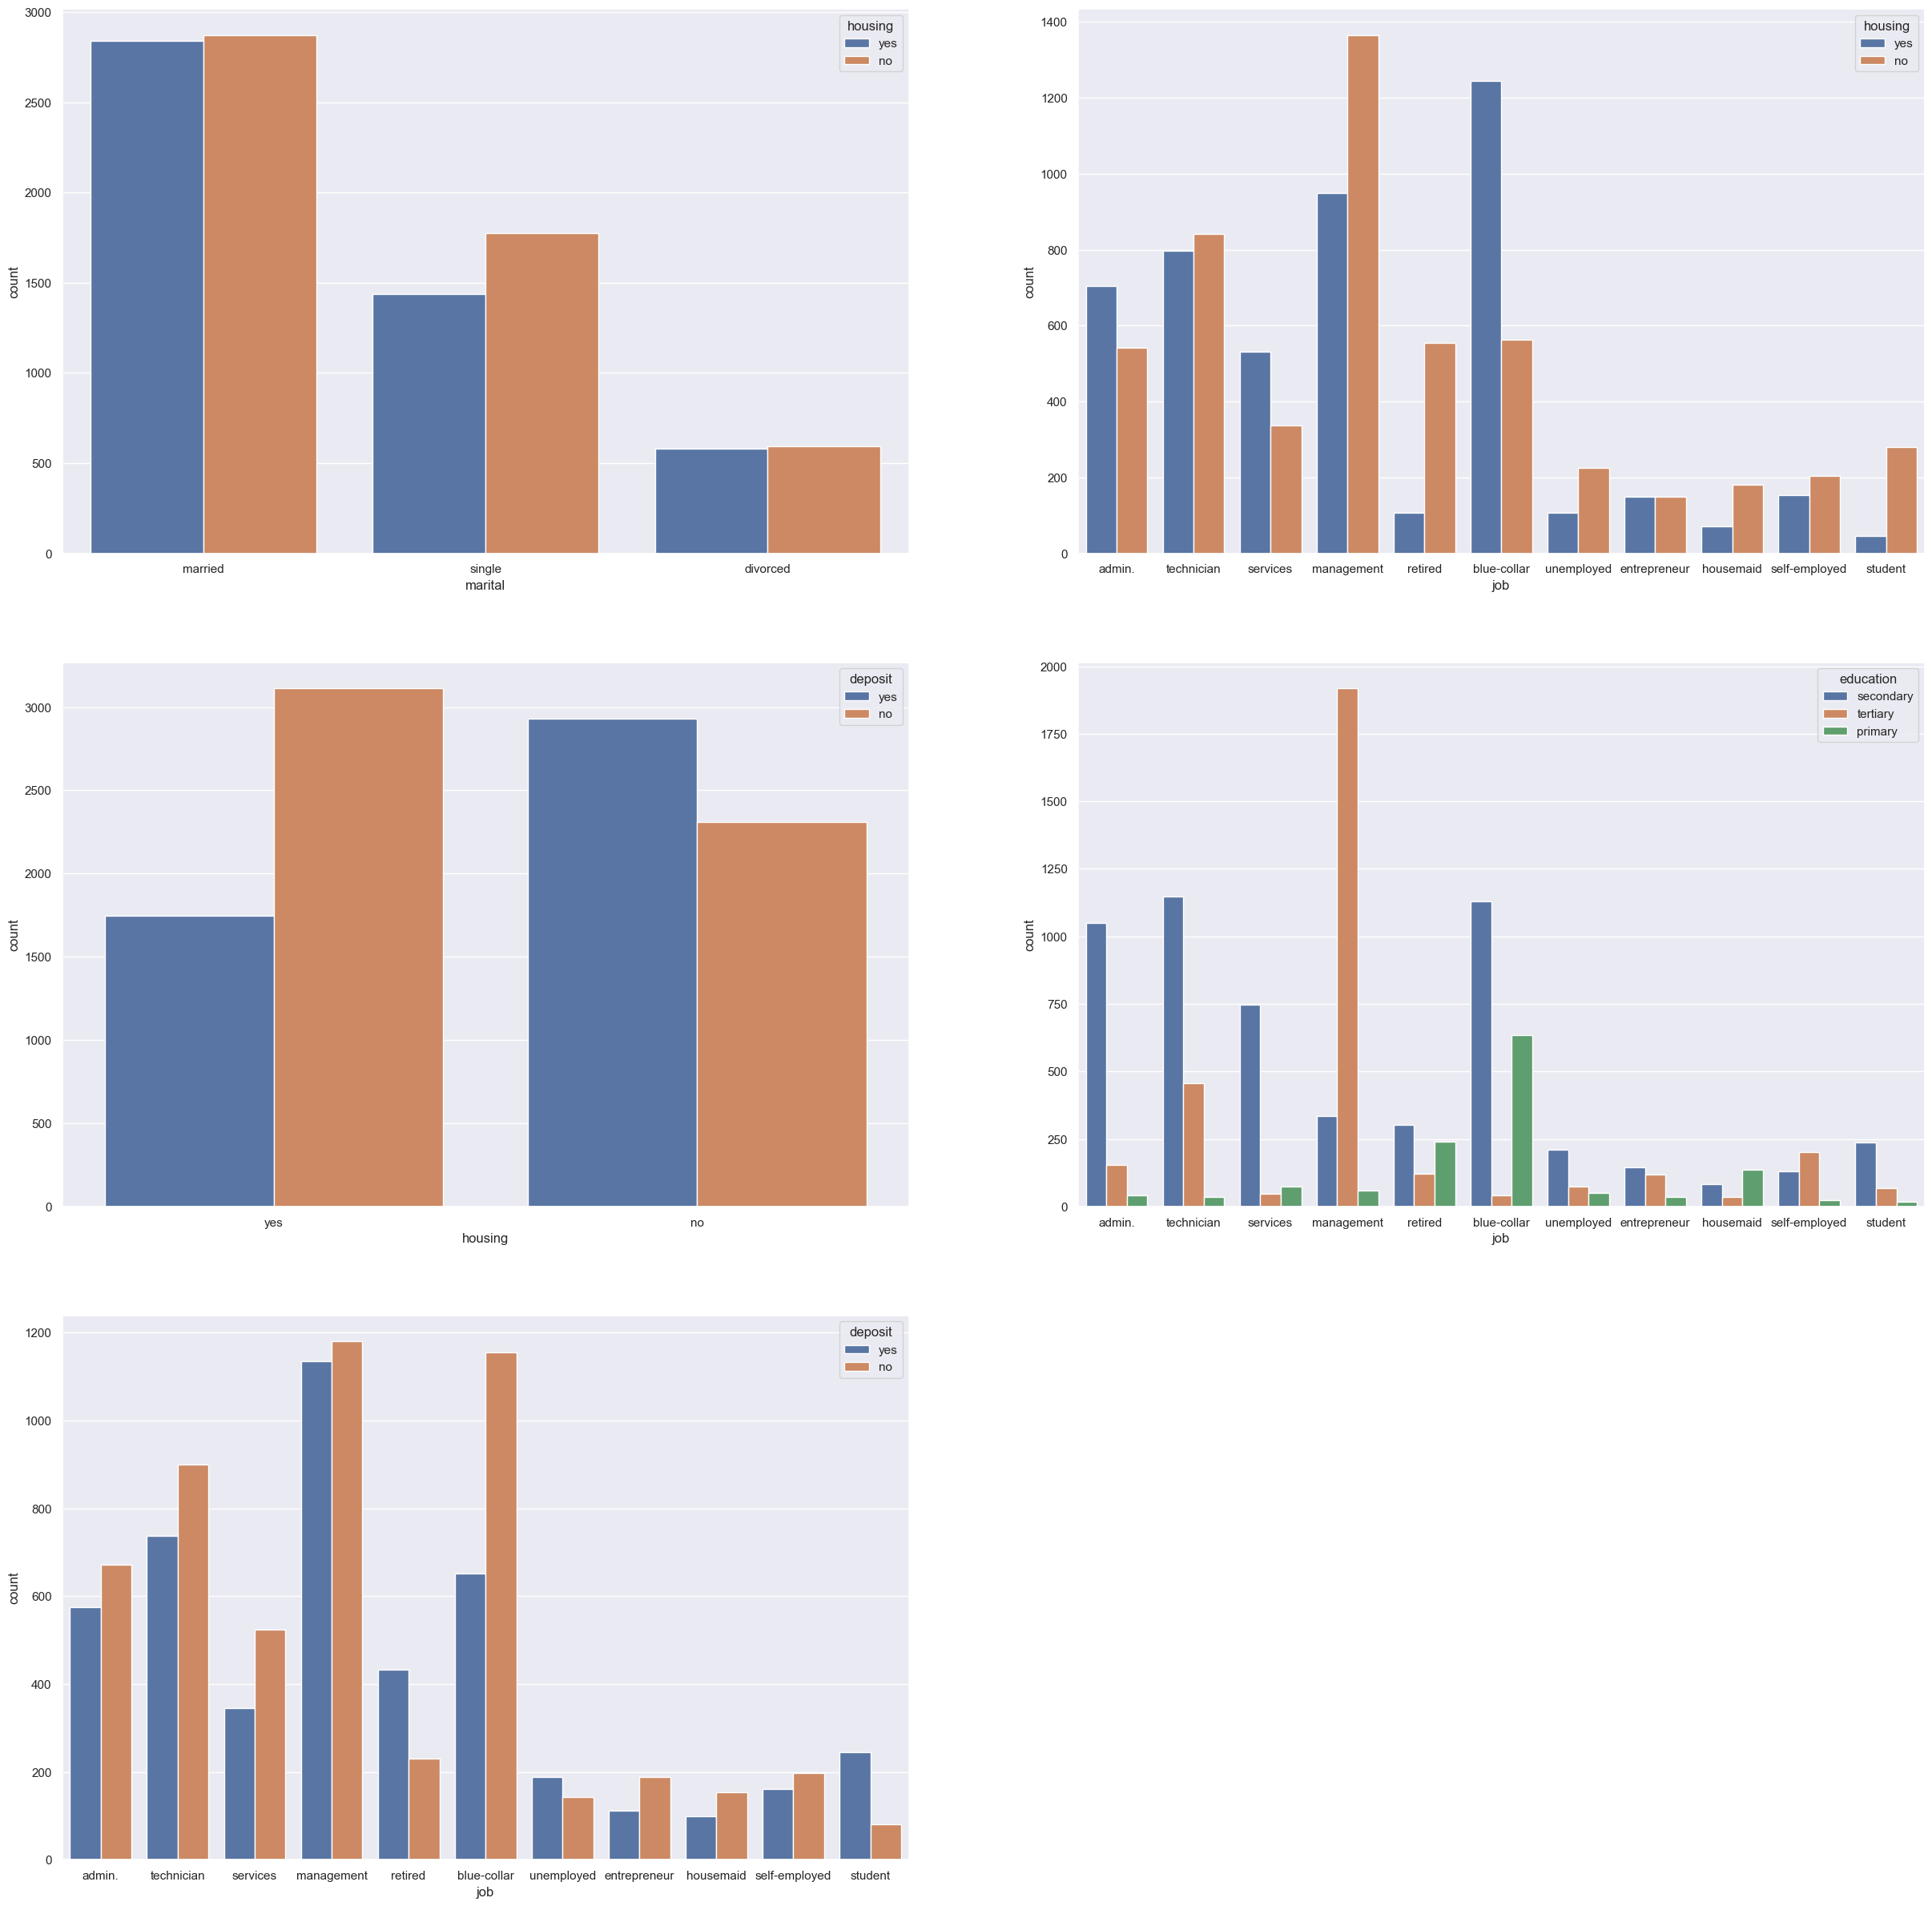

In [197]:
sns.set(rc={'figure.figsize':(30,30)})
plt.subplot(3, 2, 1)
sns.countplot(x='marital', hue='housing', data=df)
plt.subplot(3, 2, 2)
sns.countplot(x='job', hue='housing', data=df)
plt.subplot(3, 2, 3)
sns.countplot(x='housing', hue='deposit', data=df)
plt.subplot(3, 2, 4)
sns.countplot(x='job', hue='education', data=df)
plt.subplot(3, 2, 5)
sns.countplot(x='job', hue='deposit', data=df)

- Всего 11 сфер деятельности в данных
- В данных преобладают значительно больше женатых, потом одиночек и меньше всего разведенных. 
- Женатые и разведенные, имеют примерно 50 на 50 кредит на жилье, а вот одинокие преобладают тех у кого нет кредита на жилье.
- Администраторы, сервис и рабочий класс больше тех, кто имеют кредит на жилье.
- Те у кого есть кредит на жилье большинство отказываются открывать депозит в нашем банке.
- Среднее уровень образование больше всего.
- Среднее высшее образование преобладает в сферах деятельности: админ; техническое; сервис; рабочий класс (только здесь преобладают младшим уровнем образованием, чем у других)
- Высшее образование преобладает только управленческие должности.
- Май и летние месяцы преобладают в последних контактах с клиентами.
- Результаты прошлой маркетинговой кампании преобладает неизвестный итог, среди известных - неудача. 
- Категории менее платежеспособных как: студенты, безработные или в отставке. Только в них зафиксировано больше положительных решений открыть депозит в отличие от других сфер деятельности.

### Задание 6

In [198]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

df.groupby('poutcome')['deposit'].value_counts().unstack()

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


Клиенты, которые уже однажды согласились на предложение банка, более склонны принять его вновь.

### Задание 7

In [199]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
for i in np.unique(df['month']):
    print(i, round(df[(df['month'] == i)&(df['deposit'] == 'no')].shape[0]/df[df['month'] == i].shape[0],2))

apr 0.38
aug 0.56
dec 0.1
feb 0.46
jan 0.61
jul 0.59
jun 0.55
mar 0.1
may 0.68
nov 0.58
oct 0.19
sep 0.17


В мае месяца чаще всего отказывались от предложения открытя депозита.

### Задание 8

In [200]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age_group'] = pd.cut(df['age'], [0, 30, 40, 50, 60, 9999], labels=['<30', '30-40', '40-50', '50-60', '60+'])

<Axes: xlabel='age_group', ylabel='count'>

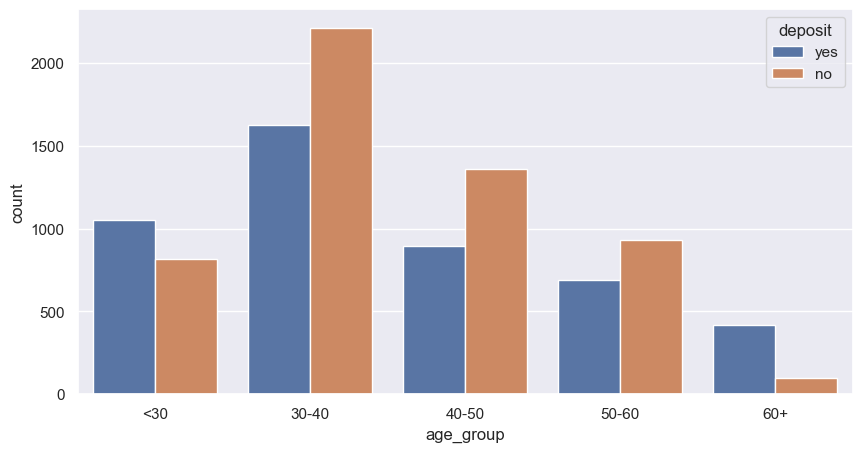

In [201]:
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(x='age_group', hue='deposit', data=df)

Молодая категория "<30" и возрастная "60+" в группе возраста более склонны к открыванию депозита.

### Задания 9 и 10

<Axes: xlabel='marital', ylabel='count'>

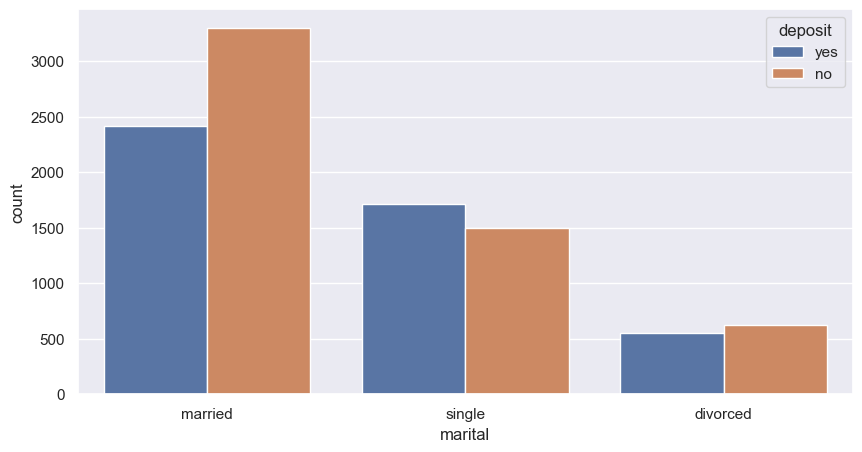

In [202]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(x='marital', hue='deposit', data=df)

<Axes: xlabel='education', ylabel='count'>

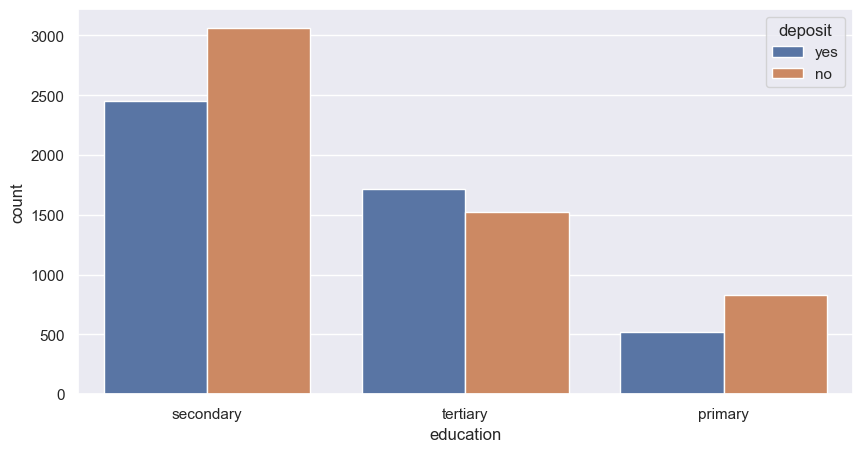

In [203]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(x='education', hue='deposit', data=df)

<Axes: xlabel='job', ylabel='count'>

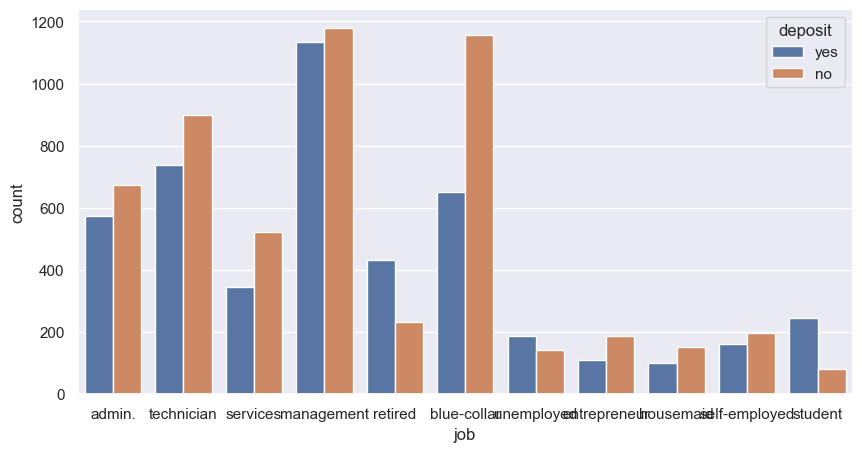

In [204]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(x='job', hue='deposit', data=df)

- К категориям *management* отностися большая часть.
- При семейном положение *single* есть тенденция открывать депозит.


### Задание 11

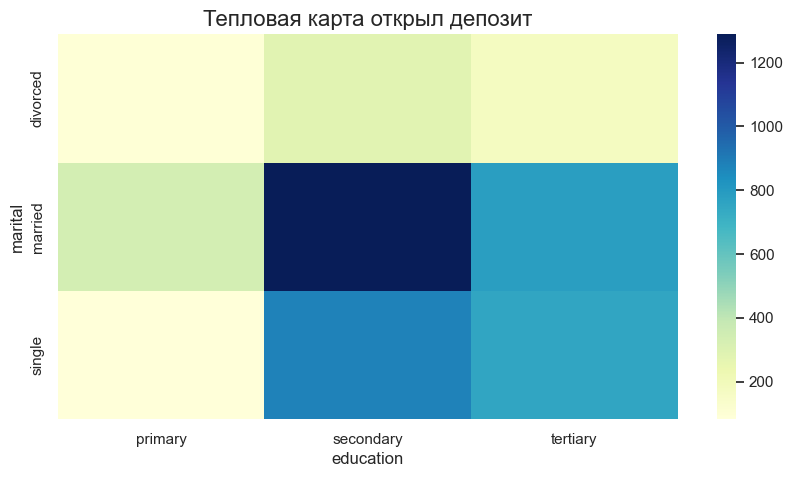

In [205]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
pivot_yes = pd.crosstab(df[df['deposit'] == 'yes']['marital'],df[df['deposit'] == 'yes']['education'])
heatmap = sns.heatmap(data=pivot_yes, cmap='YlGnBu')
heatmap.set_title('Тепловая карта открыл депозит', fontsize=16);

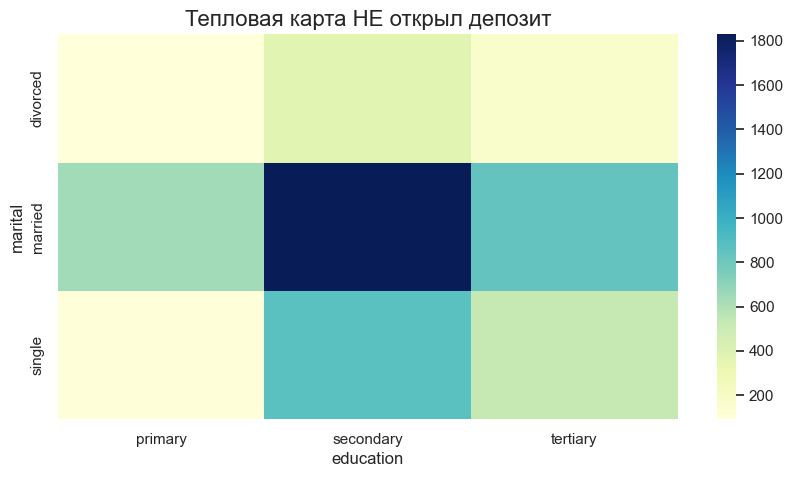

In [206]:
pivot_no = pd.crosstab(df[df['deposit'] == 'no']['marital'],df[df['deposit'] == 'no']['education'])
heatmap = sns.heatmap(data=pivot_no, cmap='YlGnBu')
heatmap.set_title('Тепловая карта НЕ открыл депозит', fontsize=16);

- Разведенные или имеющие младший уровень образования результат не меняется - одинаковый низкий результат тех кто открыл счет или кто отказал.
- Женатые и средний уровень образования одинаковый высокий результат тех кто открыл счет или отказался.
- Сочетание одиноких и имеющие средний или высший уровень образования более активно открывают счета, по сравнению с теми кто отказывается. (такой же результат у женатых и высокий уровень образования) - видно тенденцию, что люди с высоким уровнем образования более согласны на открытя счета.

## Часть 3: преобразование данных

### Задание 1

In [207]:
# преобразуйте уровни образования
labelencoder = LabelEncoder()
df['education'] = labelencoder.fit_transform(df['education'])

df['education'].sum()

11995

In [208]:
# преобразование уровня образования
df['age_group'] = labelencoder.fit_transform(df['age_group'])


### Задания 2 и 3

In [209]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

In [210]:
#стандартное отклонение  deposit
round(df['deposit'].std(),3)

0.499

In [211]:
sum_mean = round(df['default'].mean() + df['housing'].mean() + df['loan'].mean(),3)
sum_mean

0.635

### Задание 4

In [212]:
# создайте дамми-переменные
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

### Задания 5 и 6

<Axes: >

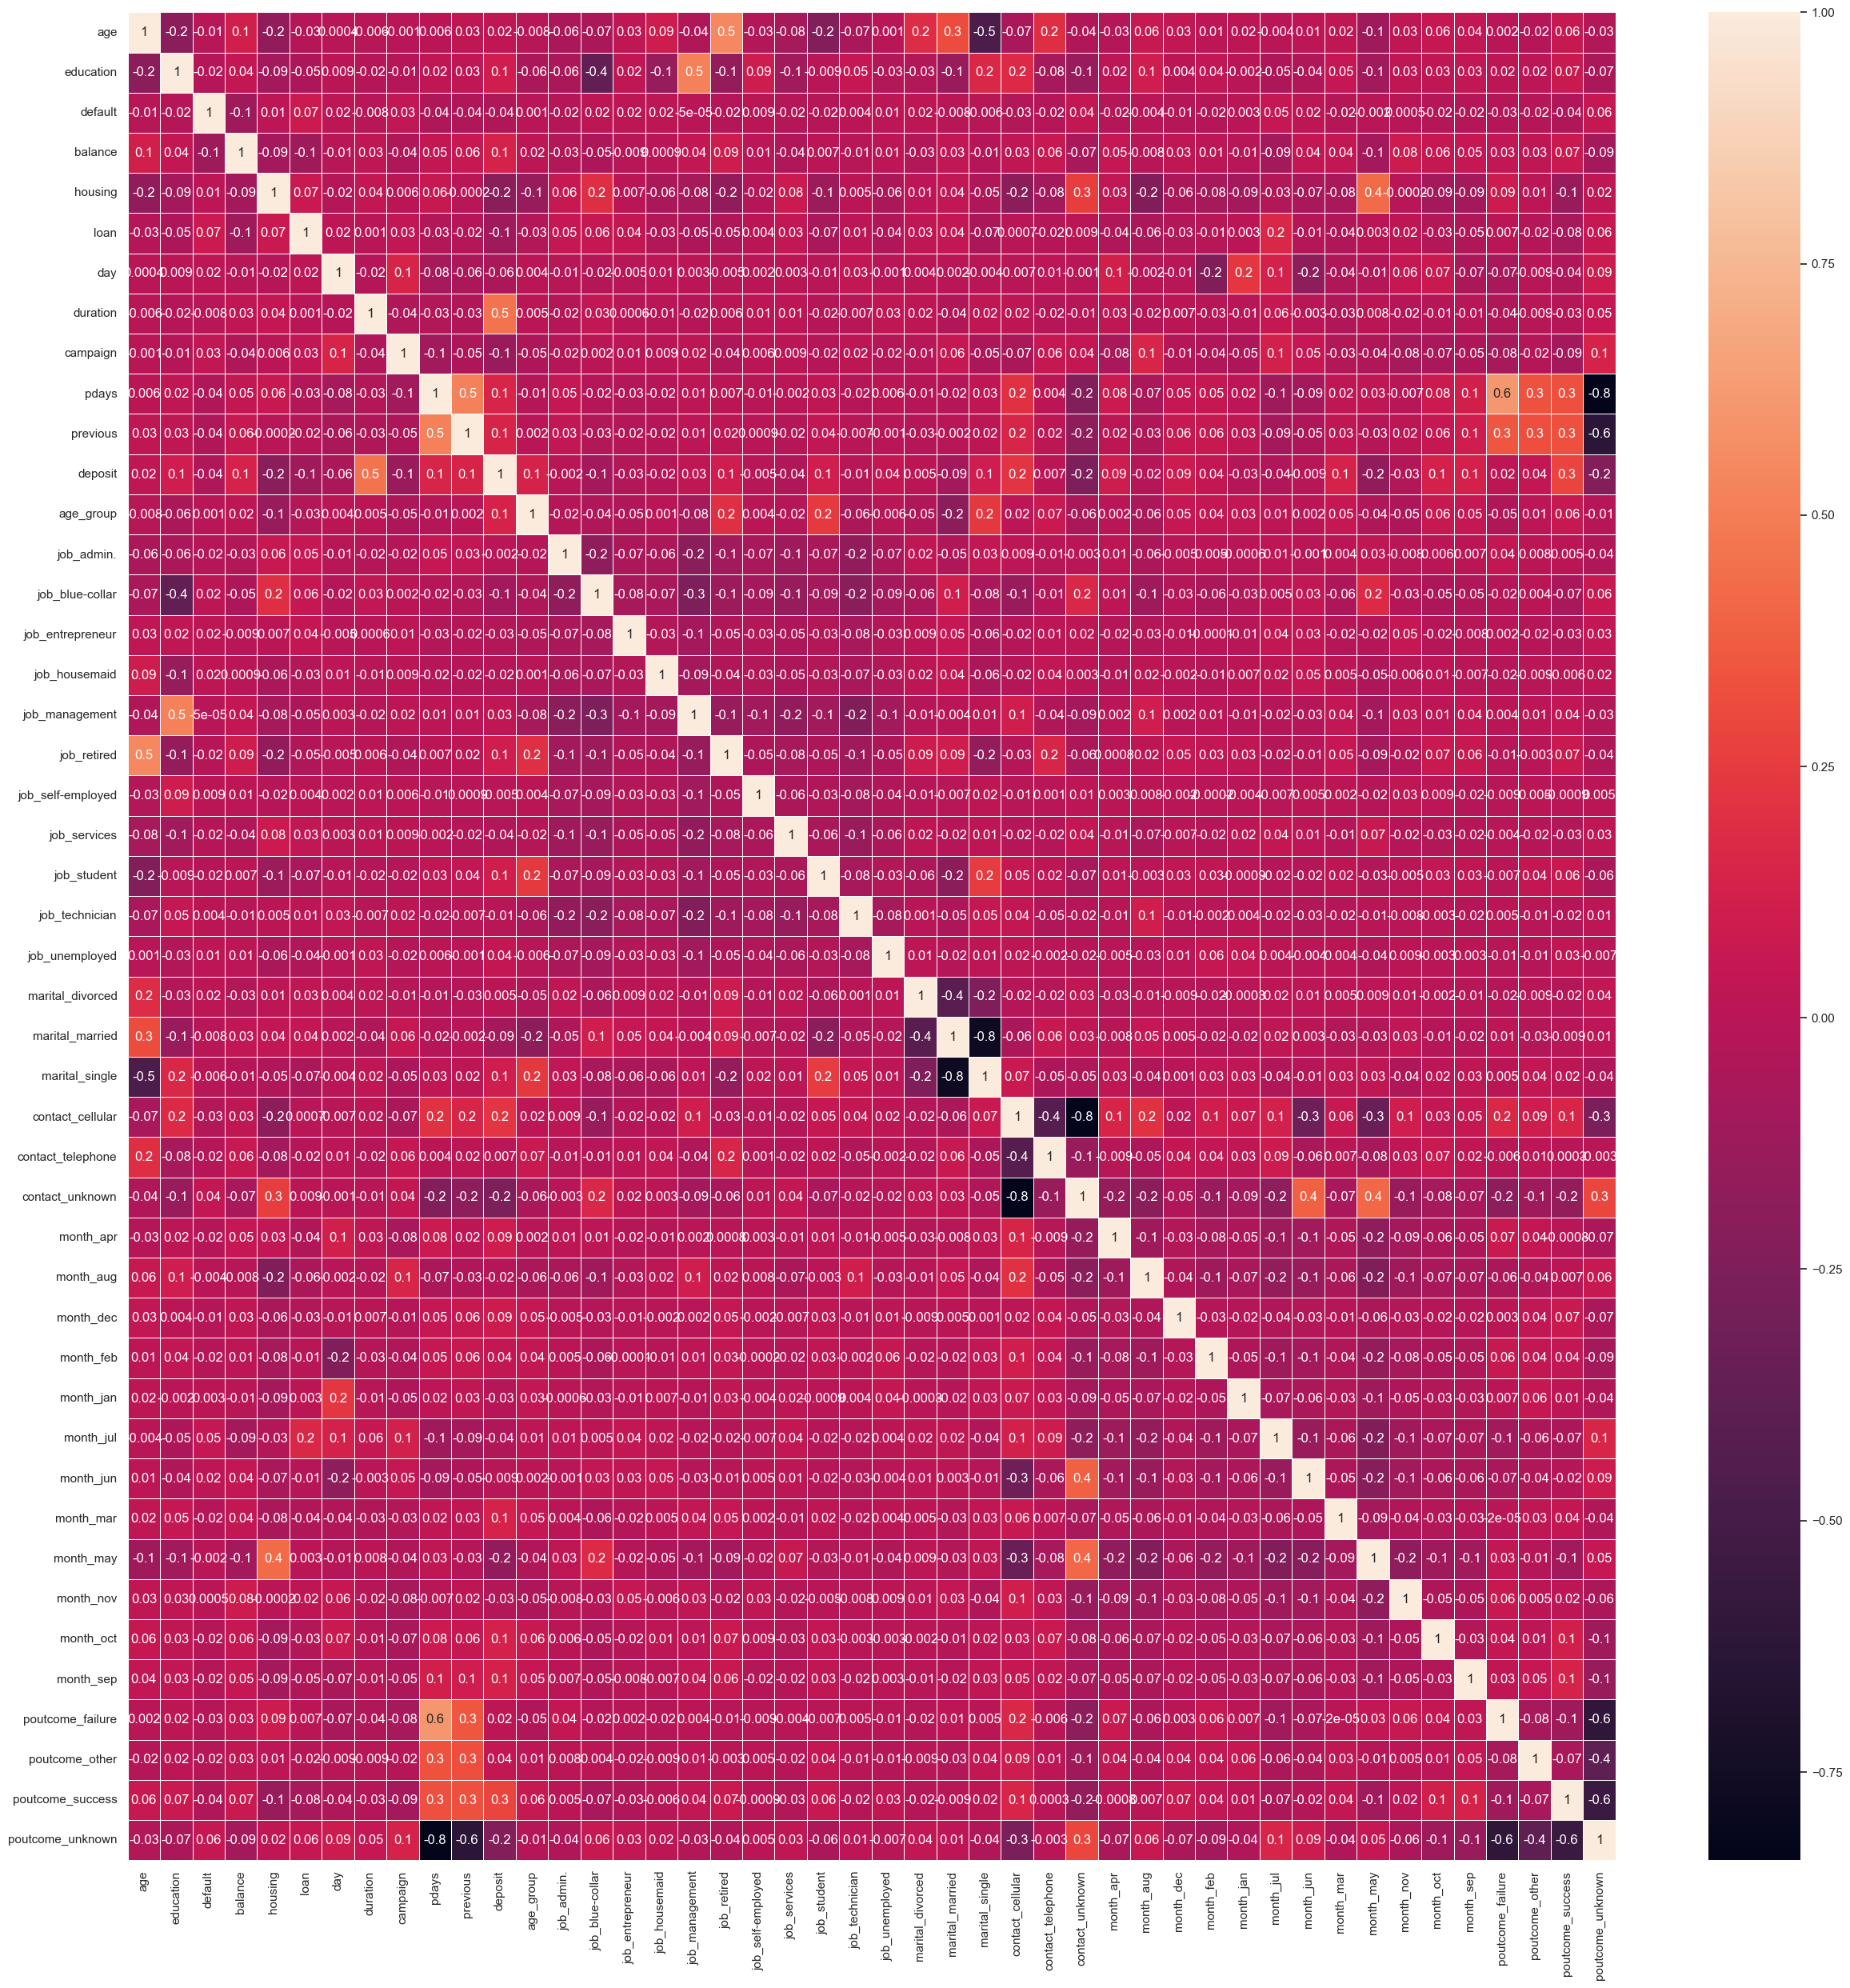

In [213]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
sns.set(rc={'figure.figsize':(30,30)})
sns.heatmap(df.corr(numeric_only=True),fmt='.1g', linewidths=.5, annot=True)

In [214]:
df_corr = round(df.corr()['deposit'].sort_values(ascending=False),2)
print(df_corr.head(5))
print()
print(df_corr.tail(5))

deposit             1.00
duration            0.46
poutcome_success    0.29
contact_cellular    0.22
pdays               0.15
Name: deposit, dtype: float64

campaign           -0.13
month_may          -0.17
housing            -0.20
poutcome_unknown   -0.23
contact_unknown    -0.25
Name: deposit, dtype: float64


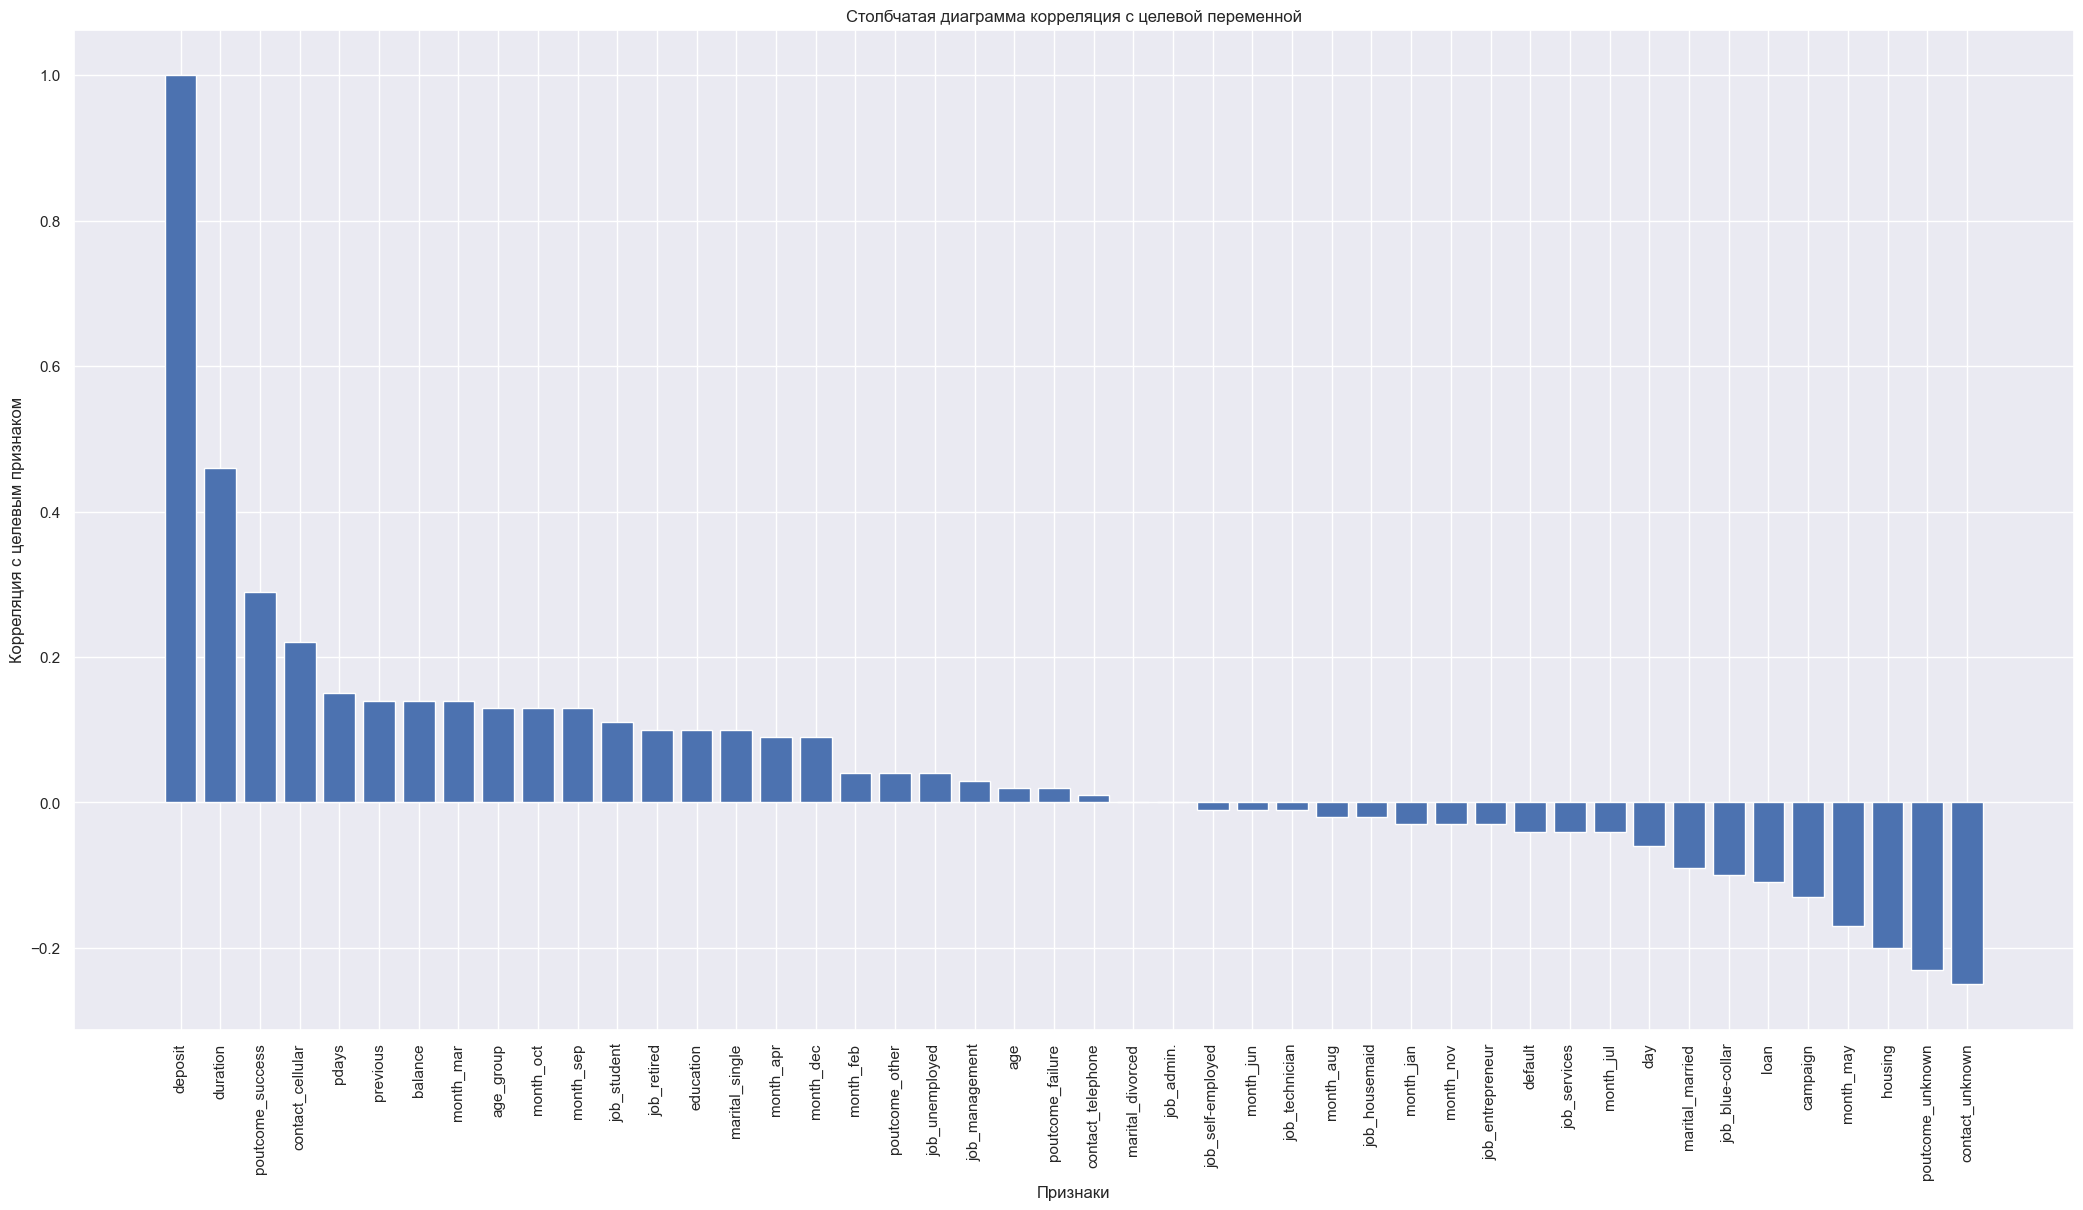

In [215]:
fig = plt.figure(figsize=(20, 10))
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(x = df_corr.index, height = df_corr);
axes.set_title('Столбчатая диаграмма корреляция с целевой переменной')
axes.set_xlabel('Признаки')
axes.set_ylabel('Корреляция с целевым признаком')
axes.xaxis.set_tick_params(rotation=90)

### Задания 7 и 8

In [216]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [217]:
# рассчитайте необходимые показатели
print(X_test.shape)
print(round(y_test.mean(),2))

(3335, 45)
0.46


### Задание 9

In [218]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)

selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [219]:
X_train_sel = X_train[['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown']]

X_test_sel = X_test[['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown']]

### Задание 10

In [220]:
# нормализуйте данные с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()
# кодируем исходный датасет
mm_scaler.fit(X_train_sel)
X_train_scaled = mm_scaler.transform(X_train_sel)
X_test_scaled = mm_scaler.transform(X_test_sel)

print(round(X_test_scaled[:,0].mean(),2))

0.47


In [221]:
column_names = selector.get_feature_names_out() 
data_X_test_select_mm = pd.DataFrame(X_test_scaled, columns=column_names)  
data_X_train_select_mm = pd.DataFrame(X_train_scaled, columns=column_names)
round(data_X_test_select_mm['balance'].mean(),2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [222]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag',
    random_state=42,
    max_iter=1000)
log_reg.fit(data_X_train_select_mm, y_train)

#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(data_X_test_select_mm)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4

In [223]:
# обучите решающие деревья, настройте максимальную глубину
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(data_X_train_select_mm, y_train)
#Выводим значения метрики
y_train_pred = dt.predict(data_X_train_select_mm)
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = dt.predict(data_X_test_select_mm)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1790
           1       0.73      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



При использовании стандартных параметров, видим, что при тренировочных данных выходят метрики идеальные, когда при тестовых в районе 0.72-0.77. Это говорит о переобучении модели.

In [224]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': [4,5,6,7,8,9,10,11,12,13]}

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state=42
    ),
    param_grid=param_grid,
    
)
grid_search.fit(data_X_train_select_mm, y_train)
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))

Наилучшие значения параметров: {'max_depth': 9}


In [225]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=6
)
#Обучаем дерево по алгоритму CART
dt.fit(data_X_train_select_mm, y_train)
#Выводим значения метрики
y_train_pred = dt.predict(data_X_train_select_mm)
print(round(metrics.accuracy_score(y_train, y_train_pred),2))
y_test_pred = dt.predict(data_X_test_select_mm)
print(round(metrics.accuracy_score(y_test, y_test_pred),2))

0.82
0.81


In [226]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=9
)
#Обучаем дерево по алгоритму CART
dt.fit(data_X_train_select_mm, y_train)
#Выводим значения метрики
y_train_pred = dt.predict(data_X_train_select_mm)
print(round(metrics.accuracy_score(y_train, y_train_pred),2))
y_test_pred = dt.predict(data_X_test_select_mm)
print(round(metrics.accuracy_score(y_test, y_test_pred),2))

0.85
0.81


Оптимальная максимальная глубина дерева равно 6, при других показателях выходит большая разница в метриках между тренировочной и тестовых наборах данных.

### Задание 5

In [227]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]}

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state=42
    ),
    param_grid=param_grid,
    cv=3,
    scoring=('f1'),
    return_train_score=True
    
)
grid_search.fit(data_X_train_select_mm, y_train)
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))


Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 7}


In [228]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=7,
    min_samples_leaf=7
)
#Обучаем дерево по алгоритму CART
dt.fit(data_X_train_select_mm, y_train)
#Выводим значения метрики
y_test_pred = dt.predict(data_X_test_select_mm)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.80


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [229]:
# обучите на ваших данных случайный лес
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion = 'gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
rf.fit(data_X_train_select_mm, y_train)
y_test_pred_rf = rf.predict(data_X_test_select_mm)
print('Accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred_rf)))
print('Recall на тестовом наборе: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred_rf)))

Accuracy на тестовом наборе: 0.83
Recall на тестовом наборе: 0.83


### Задания 2 и 3

In [230]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
#Создаем объект класса градиентного бустинг
gb = GradientBoostingClassifier(
    learning_rate= 0.05,
    n_estimators= 300,
    min_samples_leaf= 5,
    max_depth= 5,
    random_state=42
)
gb.fit(data_X_train_select_mm, y_train)
y_test_pred_gb = gb.predict(data_X_test_select_mm)
print('F1 на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_gb),))

F1 на тестовом наборе: 0.82


In [231]:
print(metrics.classification_report(y_test, y_test_pred_rf))
print(metrics.classification_report(y_test, y_test_pred_gb))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [232]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeCV
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state=42,
        max_depth=7,
        min_samples_leaf=7
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42,
        max_iter=1000
        )
    ),
    ('gb', GradientBoostingClassifier(
        learning_rate= 0.05,
        n_estimators= 300,
        min_samples_leaf= 5,
        max_depth= 5,
        random_state=42
        )
    )
]
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(
    solver='sag',
    random_state=42,
    max_iter=1000)
)
stack.fit(data_X_train_select_mm, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       min_samples_leaf=7,
                                                       random_state=42)),
                               ('log_reg',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42,
                                                      solver='sag'))

In [233]:
y_test_pred_stack = stack.predict(data_X_test_select_mm)
print('Precision на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred_stack)))

Precision на тестовом наборе: 0.81


### Задание 5

In [234]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
print(df_corr.head(3))
print()
print(df_corr.tail(1))

deposit             1.00
duration            0.46
poutcome_success    0.29
Name: deposit, dtype: float64

contact_unknown   -0.25
Name: deposit, dtype: float64


ТОП три признака по более важности к целевому признаку:
1. 'duration' (0.46 корреляция)
2. 'poutcome_success' (0.29 корреляция)
3. 'contact_unknown' (-0.25 корреляция)

### Задания 6,7,8

In [235]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=42)

    # Обучаем модель
    model.fit(data_X_train_select_mm, y_train)
    score = metrics.f1_score(y_train, model.predict(data_X_train_select_mm))

    return score



In [236]:
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-03-12 14:52:48,720] A new study created in memory with name: RandomForestClassifier
[I 2024-03-12 14:52:49,522] Trial 0 finished with value: 0.8519618571205254 and parameters: {'n_estimators': 196, 'max_depth': 15, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8519618571205254.
[I 2024-03-12 14:52:50,016] Trial 1 finished with value: 0.8898623279098874 and parameters: {'n_estimators': 104, 'max_depth': 21, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8898623279098874.
[I 2024-03-12 14:52:50,611] Trial 2 finished with value: 0.8512836568566061 and parameters: {'n_estimators': 158, 'max_depth': 30, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8898623279098874.
[I 2024-03-12 14:52:51,143] Trial 3 finished with value: 0.8537920250195467 and parameters: {'n_estimators': 139, 'max_depth': 19, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8898623279098874.
[I 2024-03-12 14:52:51,722] Trial 4 finished with value: 0.8661663539712319 and parameters: {'n_

In [237]:

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 158, 'max_depth': 26, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [238]:
model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
model.fit(data_X_train_select_mm, y_train)
y_test_pred_model = model.predict(data_X_test_select_mm)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(data_X_test_select_mm, y_test)))
print("f1_score на тестовом наборе: {:.2f}".format(metrics.f1_score(y_test, y_test_pred_model)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82
